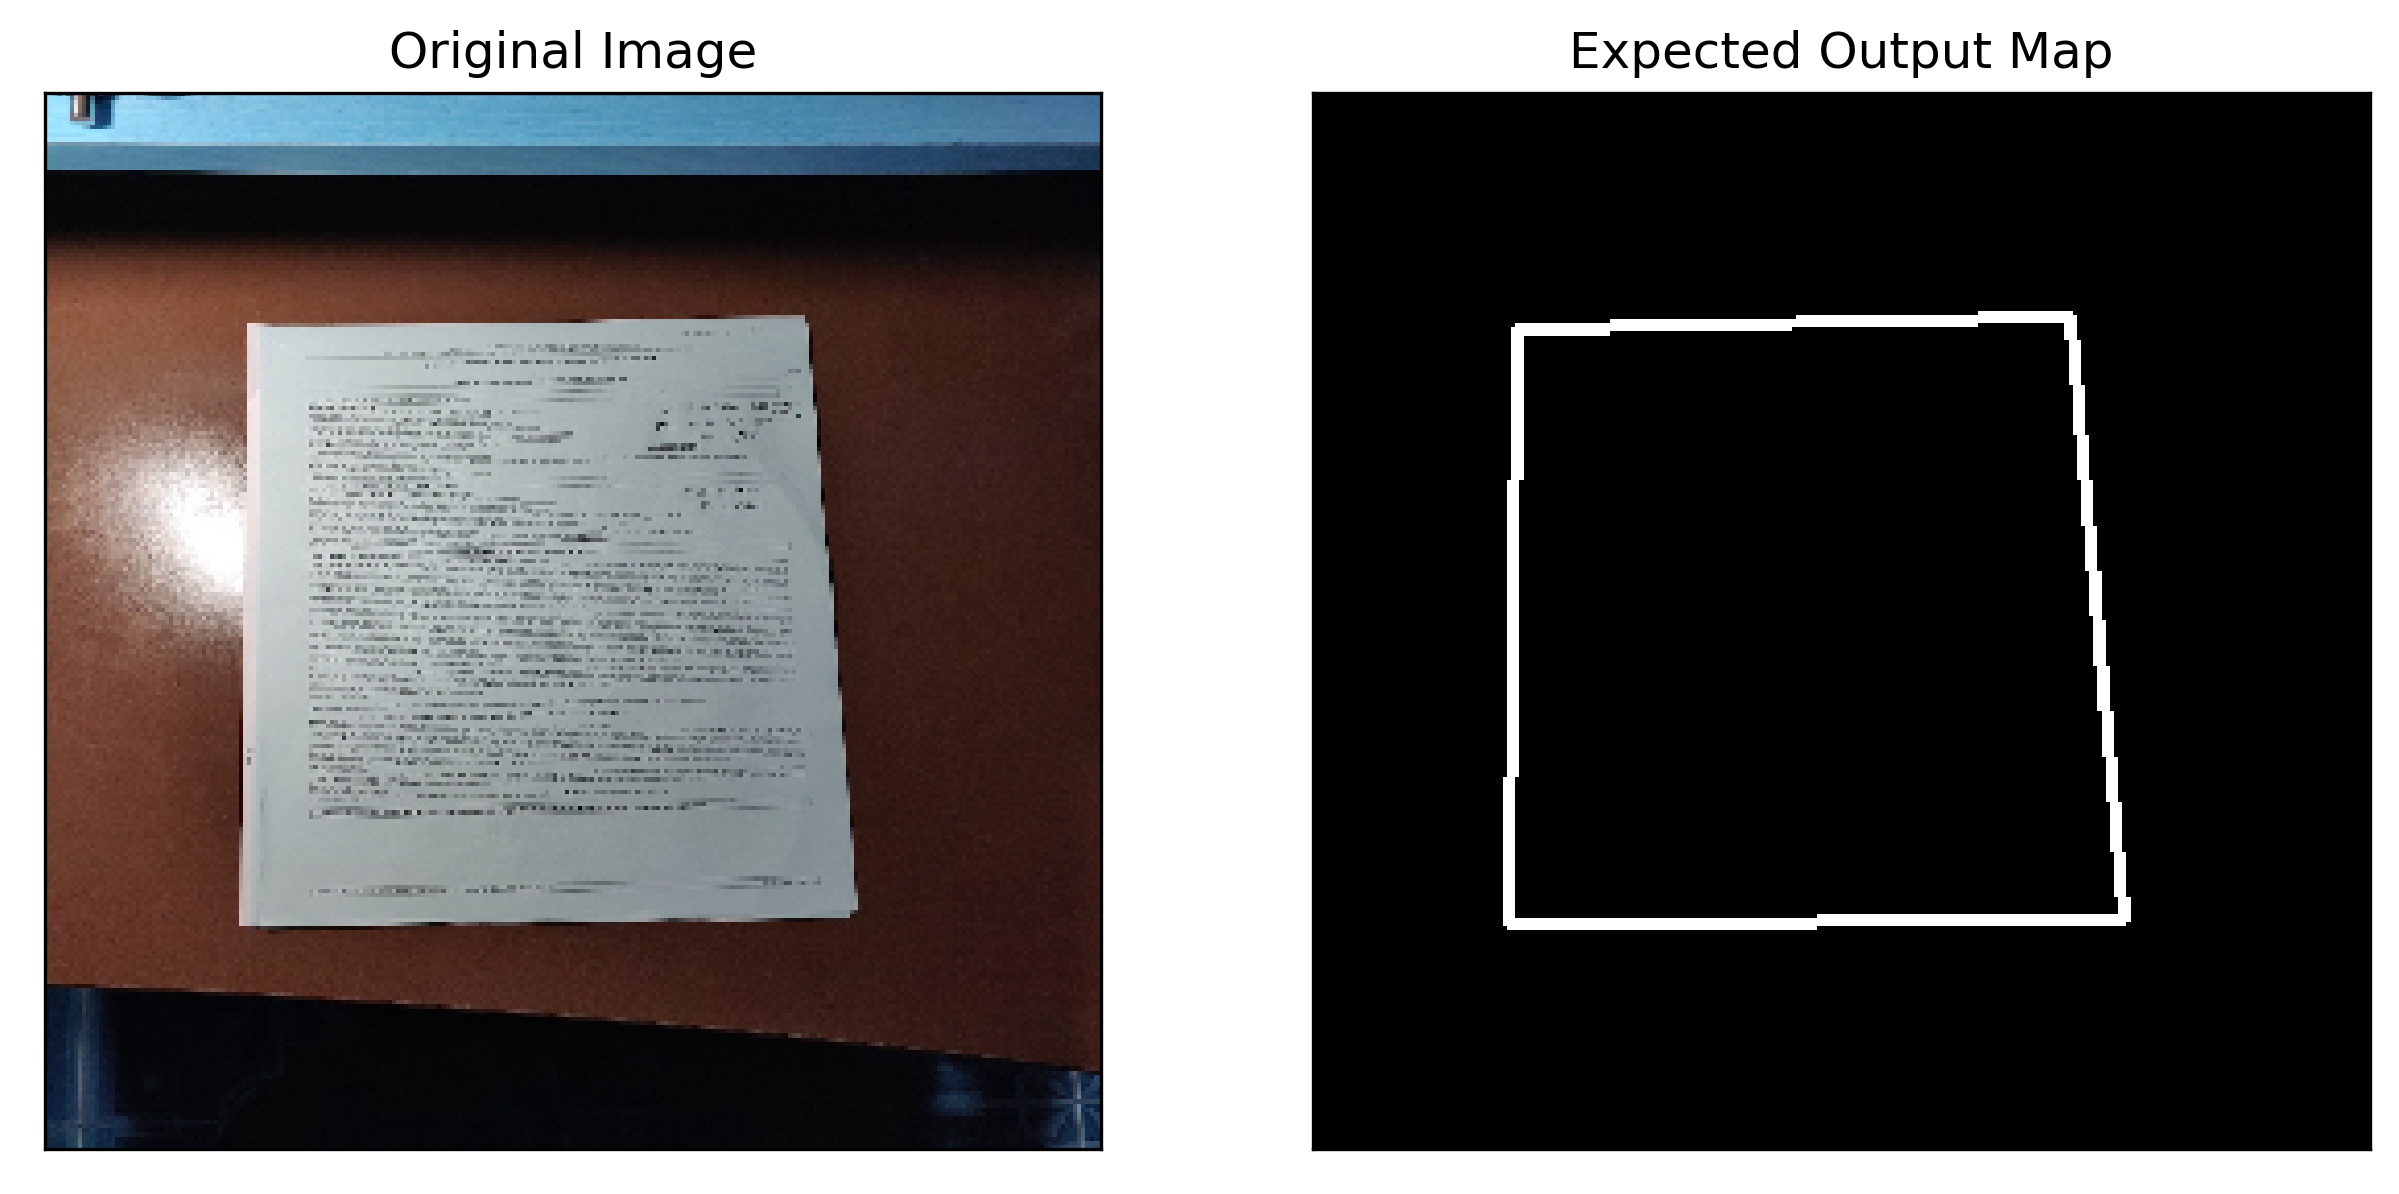

In [5]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt

IMG_RESIZE = 256
SMALL_CORNER_THICKNESS = 2

def compute_corner_image_small(img, corners):
    target = np.zeros((IMG_RESIZE, IMG_RESIZE))

    # Calculate the new corner locations in the resized image
    new_coord = corners.copy()
    new_coord[:,0] = new_coord[:,0]*IMG_RESIZE/img.shape[1]
    new_coord[:,1] = new_coord[:,1]*IMG_RESIZE/img.shape[0]

    cv2.polylines(target, np.int32([new_coord]), 1, 255, thickness=SMALL_CORNER_THICKNESS)
    #cv2.fillPoly(target, np.int32([corners]), 255)
    return target

img = cv2.imread('../../dataset/IMG_52.jpg')


corners = np.array([201,309,745,296,796,1082,194,1090]).reshape(-1,2)

img_cor = compute_corner_image_small(img, corners)
img_res = cv2.resize(img, (256, 256))

edges = cv2.Canny(img,230,240)

plt.figure(figsize=(10,10), dpi = 300)
plt.subplot(121),plt.imshow(img_res)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_cor,cmap = 'gray')
plt.title('Expected Output Map'), plt.xticks([]), plt.yticks([])

plt.show()

Text(0.5, 1, 'Corrected Output Map')

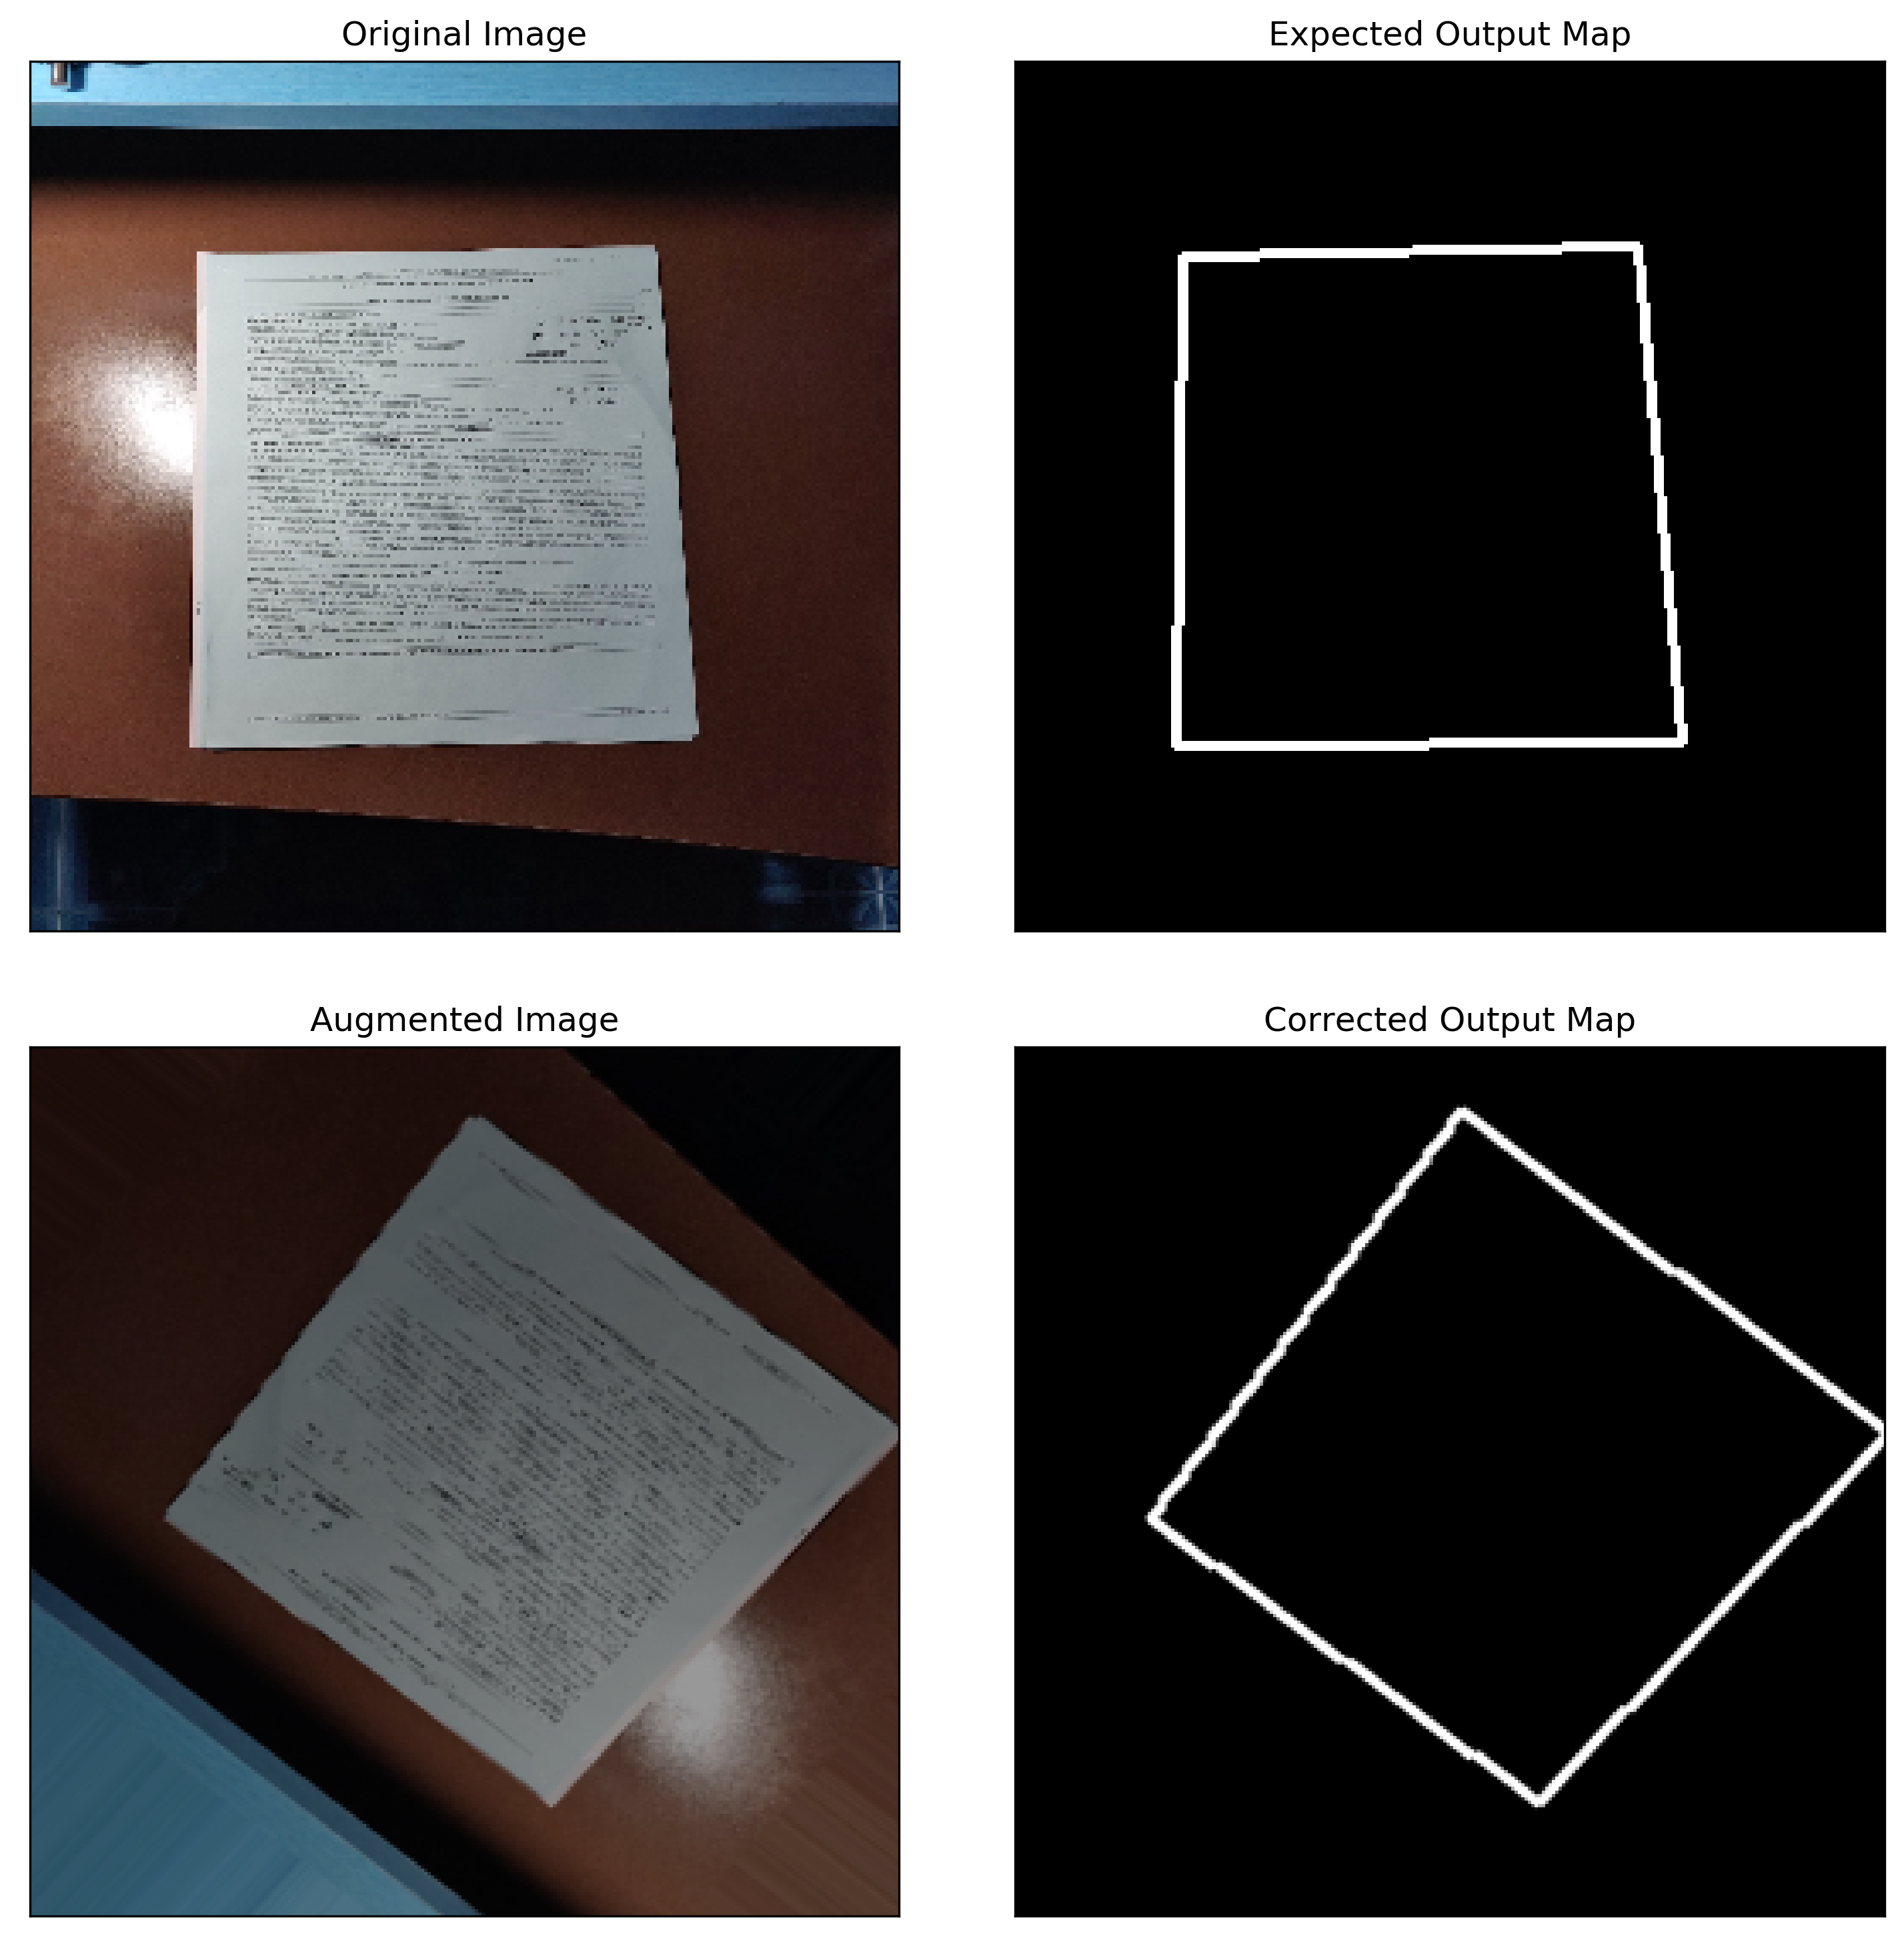

In [13]:
from keras_preprocessing.image import ImageDataGenerator
import random
from random import shuffle, randint

AUG_ROT = 90
AUG_Z = 0.2
AUG_T = 20
AUG_BRIG = 0.6

import cv2
import numpy as np
from matplotlib import pyplot as plt

IMG_RESIZE = 256
SMALL_CORNER_THICKNESS = 2

datagen = ImageDataGenerator()

def compute_corner_image_small(img, corners):
    target = np.zeros((IMG_RESIZE, IMG_RESIZE))

    # Calculate the new corner locations in the resized image
    new_coord = corners.copy()
    new_coord[:,0] = new_coord[:,0]*IMG_RESIZE/img.shape[1]
    new_coord[:,1] = new_coord[:,1]*IMG_RESIZE/img.shape[0]

    cv2.polylines(target, np.int32([new_coord]), 1, 255, thickness=SMALL_CORNER_THICKNESS)
    #cv2.fillPoly(target, np.int32([corners]), 255)
    return target

img = cv2.imread('../../dataset/IMG_52.jpg')


corners = np.array([201,309,745,296,796,1082,194,1090]).reshape(-1,2)

img_cor = compute_corner_image_small(img, corners)
img_res = cv2.resize(img, (256, 256))

rotation = randint(-AUG_ROT,AUG_ROT)
z_x = random.uniform(1-AUG_Z, 1+AUG_Z)
z_y = random.uniform(1-AUG_Z, 1+AUG_Z)
brig = random.uniform(1-AUG_BRIG, 1+AUG_BRIG)
t_x = randint(-AUG_T,AUG_T)
t_y = randint(-AUG_T,AUG_T)
flip_h = bool(random.getrandbits(1))
flip_v = bool(random.getrandbits(1))
params = {'theta':40, 'zx':z_x, 'zy':z_y, 'flip_horizontal':flip_h, 'flip_vertical':flip_v,
         "tx":t_x, "ty":t_y, "brightness": brig}
resized_img = datagen.apply_transform(x=img_res, transform_parameters=params)

# To rotate the corner image, it must be transformed to an RGB first and then back to grayscale
corner_rgb = img_cor[:,:, np.newaxis] 
corner_rgb = np.repeat(corner_rgb, 3, axis=2)
params_nobrig = {'theta':40, 'zx':z_x, 'zy':z_y, 'flip_horizontal':flip_h, 'flip_vertical':flip_v,
         "tx":t_x, "ty":t_y}

np_img = resized_img.astype('float32') / 255

rotated_corner_rgb = datagen.apply_transform(x=corner_rgb, transform_parameters=params_nobrig)
resized_corner = rotated_corner_rgb.mean(axis=2)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), dpi=300)
fig.tight_layout() # Or equivalently,  "fig.tight_layout()"

for r in axes:
    for c in r:
        c.set_xticks([])
        c.set_yticks([])

#plt.figure(, dpi = 300)
axes[0][0].imshow(img_res)
axes[0][0].set_title('Original Image')
axes[0][1].imshow(img_cor,cmap = 'gray')
axes[0][1].set_title('Expected Output Map')

axes[1][0].imshow(np_img)
axes[1][0].set_title('Augmented Image')
axes[1][1].imshow(resized_corner,cmap = 'gray')
axes[1][1].set_title('Corrected Output Map')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


AttributeError: 'Figure' object has no attribute 'imsave'

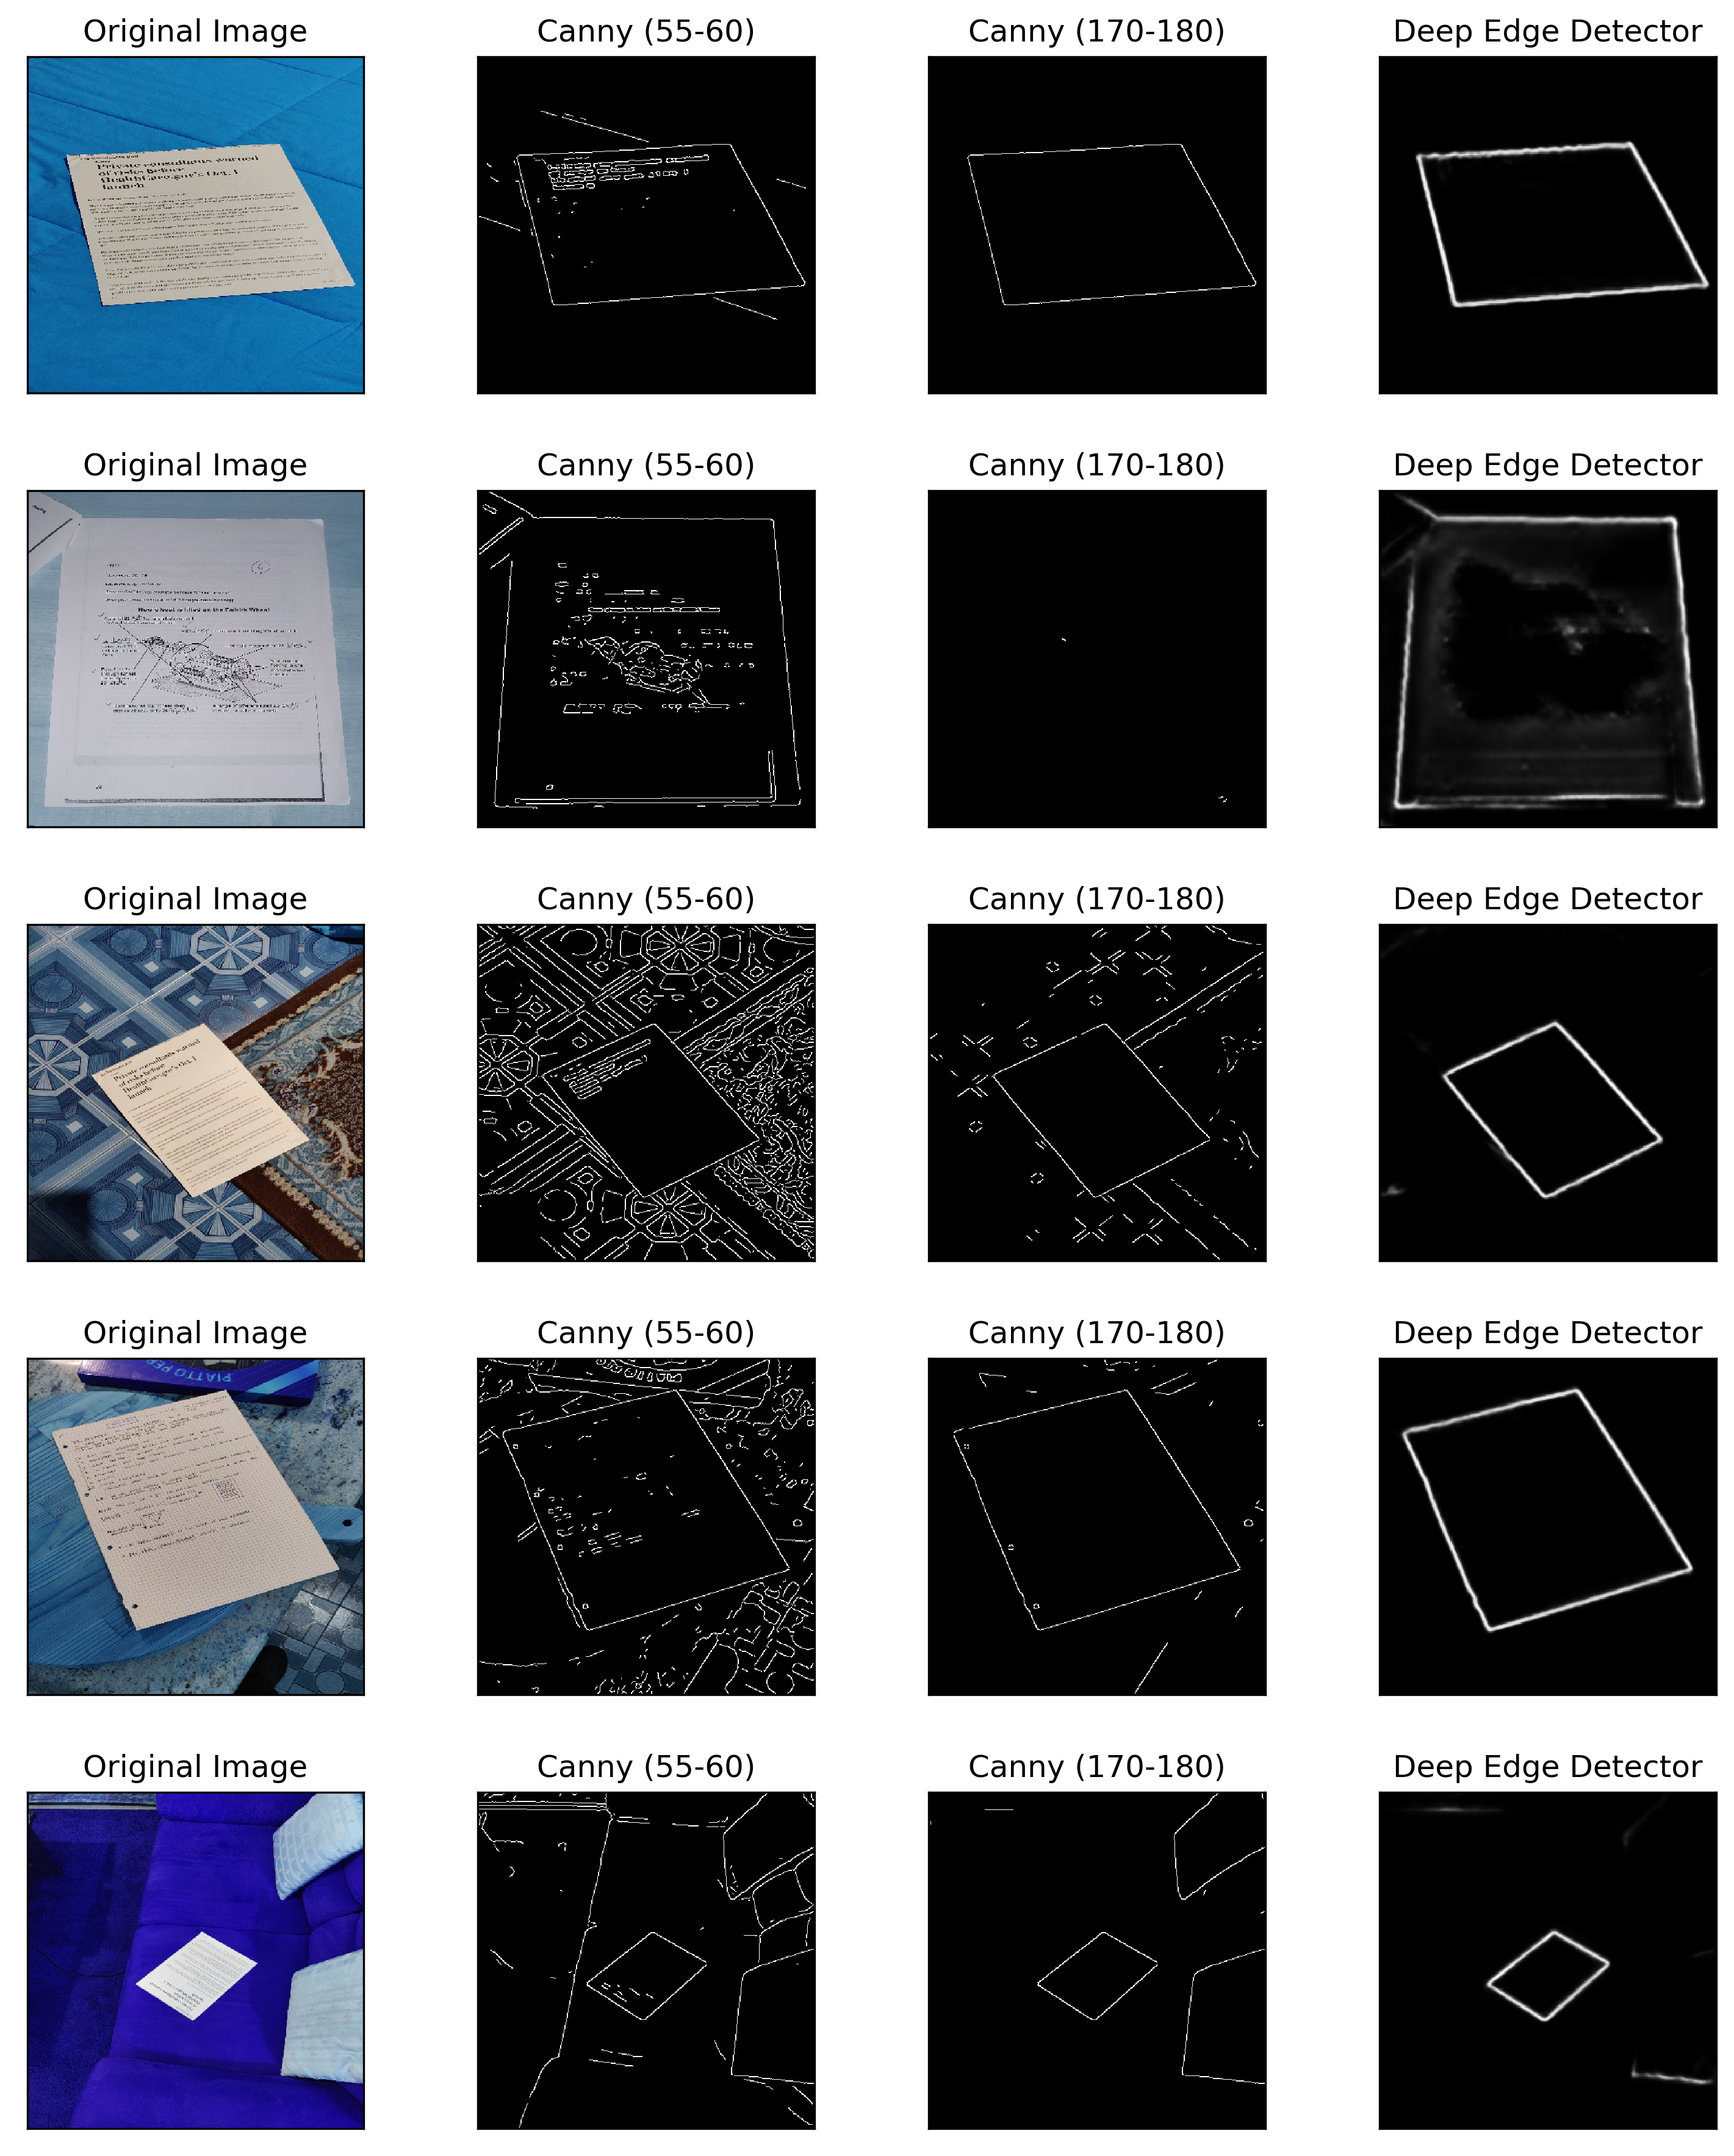

In [29]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *

# Size of the edge mask matrix
TARGET_IMAGE_SIZE = 256

class UNetEdgeDetector():
    """
    EdgeDetector implementation which uses the UNet deep learning architecture
    to detect document edges.
    Reference model: https://github.com/zhixuhao/unet
    """

    def __init__(self):
        # Define the UNet architecture in Keras
        # Reference: https://github.com/zhixuhao/unet
        input_size = (TARGET_IMAGE_SIZE,TARGET_IMAGE_SIZE,3)
        inputs = Input(input_size)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)

        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = concatenate([drop4,up6], axis = 3)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3,up7], axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2,up8], axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = concatenate([conv1,up9], axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

        self.model = Model(input = inputs, output = conv10)
        self.model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

        self.is_model_loaded = False

    def load_model(self, model_path):
        """
        Load the given keras model, saved in the .h5 format.
        """
        self.model.load_weights(model_path)
        self.is_model_loaded = True
    
    def evaluate(self, image):
        """
        Evaluate the given image, extracting the edges and returning a 256x256 mask of them.
        """
        assert self.is_model_loaded
        
        # Resize the image to the standard 256x256 input size
        resized_image = cv2.resize(image, (TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE))

        # Convert the input image to float and move it to the 0-1 range
        float_image = resized_image.astype("float32") / 255

        # Add a new dimension, needed to feed the neural network
        input_image = float_image.reshape(1, TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE, 3)

        # Feed the model and reshape the given result
        predicted_mask = self.model.predict(input_image).reshape(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE)
        
        # Convert the map to uint8 type and change range to 0-255
        uint_mask = (predicted_mask * (255/np.max(predicted_mask))).astype("uint8")

        return uint_mask



img = cv2.imread('../../dataset/IMG_6.jpg')
img = cv2.resize(img, (400, 400))
blurred = cv2.GaussianBlur(img,(11,11),0)
edges1 = cv2.Canny(blurred,55,60)

blurred = cv2.GaussianBlur(img,(11,11),0)
edges2 = cv2.Canny(blurred,170,180)

img2 = cv2.imread('../../dataset/IMG_4.jpg')
img2 = cv2.resize(img2, (400, 400))
blurred = cv2.GaussianBlur(img2,(11,11),0)
edges3 = cv2.Canny(blurred,55,60)

blurred = cv2.GaussianBlur(img2,(11,11),0)
edges4 = cv2.Canny(blurred,170,180)

img3= cv2.imread('../../dataset/IMG_7.jpg')
img3 = cv2.resize(img3, (400, 400))
blurred = cv2.GaussianBlur(img3,(11,11),0)
edges5 = cv2.Canny(blurred,55,60)

blurred = cv2.GaussianBlur(img3,(11,11),0)
edges6 = cv2.Canny(blurred,170,180)

img4= cv2.imread('../../dataset/IMG_8.jpg')
img4 = cv2.resize(img4, (400, 400))
blurred = cv2.GaussianBlur(img4,(11,11),0)
edges7 = cv2.Canny(blurred,55,60)

blurred = cv2.GaussianBlur(img4,(11,11),0)
edges8 = cv2.Canny(blurred,170,180)

img5= cv2.imread('../../dataset/IMG_25.jpg')
img5 = cv2.resize(img5, (400, 400))
blurred = cv2.GaussianBlur(img5,(11,11),0)
edges9 = cv2.Canny(blurred,55,60)

blurred = cv2.GaussianBlur(img5,(11,11),0)
edges10 = cv2.Canny(blurred,170,180)

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10,12), dpi=300)
fig.tight_layout() # Or equivalently,  "fig.tight_layout()"

d = UNetEdgeDetector()
d.load_model("../../models/unet-nob-70.h5")

for r in axes:
    for c in r:
        c.set_xticks([])
        c.set_yticks([])

#plt.figure(, dpi = 300)
axes[0][0].imshow(img)
axes[0][0].set_title('Original Image')
axes[0][1].imshow(edges1,cmap = 'gray')
axes[0][1].set_title('Canny (55-60)')
axes[0][2].imshow(edges2,cmap = 'gray')
axes[0][2].set_title('Canny (170-180)')
axes[0][3].imshow(d.evaluate(img),cmap = 'gray')
axes[0][3].set_title('Deep Edge Detector')

axes[1][0].imshow(img2)
axes[1][0].set_title('Original Image')
axes[1][1].imshow(edges3,cmap = 'gray')
axes[1][1].set_title('Canny (55-60)')
axes[1][2].imshow(edges4,cmap = 'gray')
axes[1][2].set_title('Canny (170-180)')
axes[1][3].imshow(d.evaluate(img2),cmap = 'gray')
axes[1][3].set_title('Deep Edge Detector')

axes[2][0].imshow(img3)
axes[2][0].set_title('Original Image')
axes[2][1].imshow(edges5,cmap = 'gray')
axes[2][1].set_title('Canny (55-60)')
axes[2][2].imshow(edges6,cmap = 'gray')
axes[2][2].set_title('Canny (170-180)')
axes[2][3].imshow(d.evaluate(img3),cmap = 'gray')
axes[2][3].set_title('Deep Edge Detector')

axes[3][0].imshow(img4)
axes[3][0].set_title('Original Image')
axes[3][1].imshow(edges7,cmap = 'gray')
axes[3][1].set_title('Canny (55-60)')
axes[3][2].imshow(edges8,cmap = 'gray')
axes[3][2].set_title('Canny (170-180)')
axes[3][3].imshow(d.evaluate(img4),cmap = 'gray')
axes[3][3].set_title('Deep Edge Detector')

axes[4][0].imshow(img5)
axes[4][0].set_title('Original Image')
axes[4][1].imshow(edges9,cmap = 'gray')
axes[4][1].set_title('Canny (55-60)')
axes[4][2].imshow(edges10,cmap = 'gray')
axes[4][2].set_title('Canny (170-180)')
axes[4][3].imshow(d.evaluate(img5),cmap = 'gray')
axes[4][3].set_title('Deep Edge Detector')

plt.show()
#fig.imsave("deep_edge_comparison.png")